In [ ]:
%matplotlib notebook

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 1, 28, 28])
Shape of y:  torch.Size([64]) torch.int64


In [ ]:
# Randomly drops values in a tensor to zero with probability p
def drop_data(data, p, device):
    return (torch.rand(data.shape) < (1-p)).to(device).int() * data

In [ ]:
# A small denoising autoencoder model with 0.25 of input data dropped
class DenoisingAE(nn.Module):
    def __init__(self):
        super(DenoisingAE, self).__init__()
        self.flatten = nn.Flatten()
        self.add_noise = drop_data
        self.encode = nn.Sequential(
            nn.Linear(28*28, 250),
            nn.ReLU(),
            nn.Linear(250, 50),
            nn.ReLU(),
            nn.Linear(50, 3),
        )
        self.decode = nn.Sequential(
            nn.Linear(3, 50),
            nn.ReLU(),
            nn.Linear(50, 250),
            nn.ReLU(),
            nn.Linear(250, 28*28)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.add_noise(x, 0.25, device)
        x = self.encode(x)
        x = self.decode(x)
        return x
    

In [ ]:
# Set device, loss function, and optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model = DenoisingAE().to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay=1e-5)

In [ ]:
# Train model for one epoch
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(torch.reshape(pred, (X.shape[0], 1, 28, 28)), X)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
# Evaluate model accuracy on one batch
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            pred = model(X)
            test_loss += loss_fn(torch.reshape(pred, (X.shape[0], 1, 28, 28)), X).item()
    test_loss /= num_batches
    print(f"Avg loss: {test_loss:>8f} \n")

In [ ]:
# Train model and output losses for 50 epochs
epochs = 50
for t in range(epochs):
    print(f"Epoch {t+1}")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
Avg loss: 0.026247 

Epoch 2
Avg loss: 0.024993 

Epoch 3
Avg loss: 0.024192 

Epoch 4
Avg loss: 0.024121 

Epoch 5
Avg loss: 0.023908 

Epoch 6
Avg loss: 0.023491 

Epoch 7
Avg loss: 0.023254 

Epoch 8
Avg loss: 0.023219 

Epoch 9
Avg loss: 0.023320 

Epoch 10
Avg loss: 0.023045 

Epoch 11
Avg loss: 0.023053 

Epoch 12
Avg loss: 0.022903 

Epoch 13
Avg loss: 0.022997 

Epoch 14
Avg loss: 0.022917 

Epoch 15
Avg loss: 0.022796 

Epoch 16
Avg loss: 0.022845 

Epoch 17
Avg loss: 0.022678 

Epoch 18
Avg loss: 0.022699 

Epoch 19
Avg loss: 0.022652 

Epoch 20
Avg loss: 0.022712 

Epoch 21
Avg loss: 0.022564 

Epoch 22
Avg loss: 0.022551 

Epoch 23
Avg loss: 0.022646 

Epoch 24
Avg loss: 0.022641 

Epoch 25
Avg loss: 0.022514 

Epoch 26
Avg loss: 0.022506 

Epoch 27
Avg loss: 0.022465 

Epoch 28
Avg loss: 0.022418 

Epoch 29
Avg loss: 0.022558 

Epoch 30
Avg loss: 0.022411 

Epoch 31
Avg loss: 0.022458 

Epoch 32
Avg loss: 0.022389 

Epoch 33
Avg loss: 0.022336 

Epoch 34
Avg loss: 

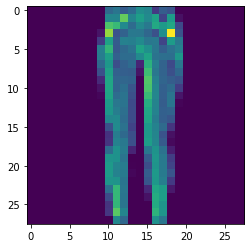

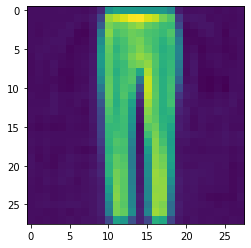

In [ ]:
# Display a random image from test data and its reconstruction
image = test_data[np.random.randint(len(test_data))][0]
plt.imshow(torch.reshape(image, (28, 28)))
plt.show()
output = torch.reshape(model(image.to(device)), (28, 28))
plt.imshow(output.detach().cpu())
plt.show()

In [ ]:
with torch.no_grad():
  encodings = []
  classes = []
  for image, obj in test_data: 
    encodings.append(model.encode(torch.reshape(image, (28 * 28,)).to(device)).cpu().numpy())
    classes.append(obj)
encodings = np.array(encodings)
clothing = {0: "tee/top",
            1: "trouser",
            2: "pullover",
            3: "dress",
            4: "coat",
            5: "sandal",
            6: "shirt",
            7: "sneaker",
            8: "bag",
            9: "ankle boot"}
classes = [clothing[i] for i in classes]

In [ ]:
import plotly.express as px
import pandas as pd
fig = px.scatter_3d(x=encodings[:, 0], y=encodings[:, 1], z=encodings[:, 2], color=classes)
fig.show()